# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">😴 Pogchamps 4 😴 - Predicting Sleep </center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;"> Sleep prediction from personal health device data: Fitbit, Apple Watch, and iPhone</center></p>

***

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>Table of contents</b></div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">

* [0. Import all dependencies](#0)
* [1.Overview of Available Data](#1)
    * [1.1 Overview train/ directory](#1.1)
    * [1.2 Overview test/ directory](#1.2)
    * [1.3 Overview unlabeled/ directory](#1.3)
* [2. Time Series Forecasting](#2)
    * [2.1 Facebook Prophet](#2.1)
    * [2.2 ARIMA](#2.2)
    * [2.3 XGBoost](#2.3)
        * [2.3.1 Hyperparameter Tuning with Hyperopt](#2.3.1)
    
* [3. Submission](#3)

<a id="0"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 0. Import all dependencies </b></div>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima                        
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. Overview of Available Data </b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ The data series include four datasets:</p>

* <p style="font-family: consolas; font-size: 16px;">The <b>raw_health_export.xml</b> file of 8 years of historic health data taken from various devices including: Fitbit, Apple Watch and iPhone. </p>
* <p style="font-family: consolas; font-size: 16px;">The <b>train.csv</b> dataset, comprising just date and sleep hours recorded.</p>
* <p style="font-family: consolas; font-size: 16px;">The <b>train_detailed.csv</b> dataset, comprising a more detailed time series </p>
* <p style="font-family: consolas; font-size: 16px;">The <b>test.csv</b> dataset comprising of the dates required for the prediction and format</p>


<a id="1.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.1 Overview of <i>training data</b></div>

In [3]:
train = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/train.csv')
train_detailed = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/train_detailed.csv')
test = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/test.csv')

In [4]:
test.tail()

,date,sleep_hours
414,2023-03-12,1
415,2023-03-13,1
416,2023-03-14,1
417,2023-03-15,1
418,2023-03-16,1


<AxesSubplot:>

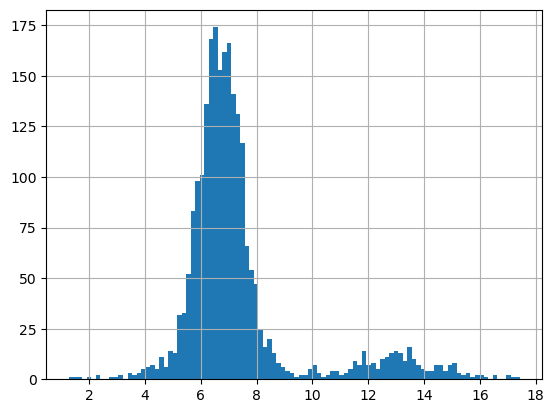

In [5]:
train['sleep_hours'].hist(bins=100)

In [6]:
train['date']=pd.to_datetime(train['date'])

In [7]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py

# Creating trace1
trace1 = go.Scatter(
                    x = train.date,
                    y = train.sleep_hours,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'))

data = [trace1]
layout = dict(title = 'Rob Mulla Sleeping Hours',
              xaxis= dict(title= 'Date',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

<p style="font-family: consolas; font-size: 16px;">It looks like there is an artificial increase in the sleep_hours end of Sept 29th 2017- Jun 12th 2018. Maybe this is Rob throwing off time-series predictions? We could manually adjust to bring it back into line? </p>





In [8]:
train[(train["date"] >= "2017-09-29") & (train["date"] <= "2018-06-12")].mean()/ train[(train["date"] <= "2017-09-28")].mean()

sleep_hours    1.940106
dtype: float64

<p style="font-family: consolas; font-size: 16px;">This period is 1.94 times the size. So let's average adjust and divide all these values in this range by 1.94 </p>


In [9]:
train_adj = train.copy()
train_adj['sleep_hours'].loc[(train_adj["date"] >= "2017-09-27") & (train_adj["date"] <= "2018-06-12")] = train_adj['sleep_hours']/1.94



In [10]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py

# Creating trace1
trace1 = go.Scatter(
                    x = train_adj.date,
                    y = train_adj.sleep_hours,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'))

data = [trace1]
layout = dict(title = 'Rob Mulla Sleeping Hours',
              xaxis= dict(title= 'Date',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

<p style="font-family: consolas; font-size: 16px;">That looks more reasonable. The start of the time series looks slightly erractic, we might want to trim it - July 20th 2015 looks like a good start date</p>


In [11]:
train_adj = train_adj.loc[(train_adj['date']>"2015-07-20")]
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py

# Creating trace1
trace1 = go.Scatter(
                    x = train_adj.date,
                    y = train_adj.sleep_hours,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'))

data = [trace1]
layout = dict(title = 'Rob Mulla Sleeping Hours',
              xaxis= dict(title= 'Date',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

<p style="font-family: consolas; font-size: 16px;">Maybe we should explore whether Rob has been lying in at the weekend?</p>


In [12]:
train_adj["day_of_week"] = train_adj['date'].dt.day_name()
train_adj

,date,sleep_hours,day_of_week
52,2015-07-21,7.850000,Tuesday
53,2015-07-22,5.916667,Wednesday
54,2015-07-23,6.916667,Thursday
55,2015-07-24,6.450000,Friday
56,2015-07-25,7.783333,Saturday
...,...,...,...
2349,2021-12-25,7.933333,Saturday
2350,2021-12-26,3.850000,Sunday
2351,2021-12-29,6.175000,Wednesday
2352,2021-12-30,5.158333,Thursday


<AxesSubplot:xlabel='day_of_week'>

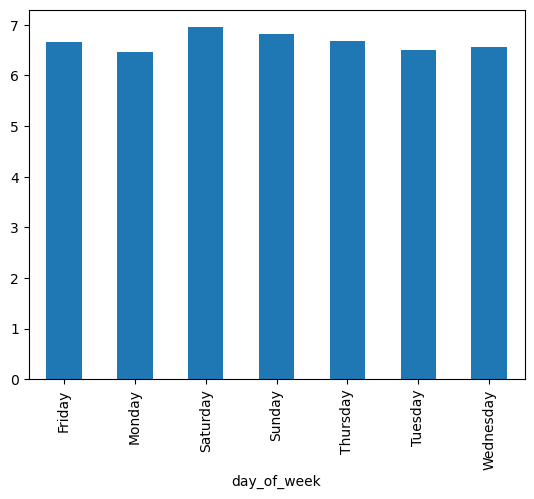

In [13]:
train_adj[['day_of_week', 'sleep_hours']].groupby('day_of_week').mean().sort_index().plot(kind='bar', legend=None)

<AxesSubplot:>

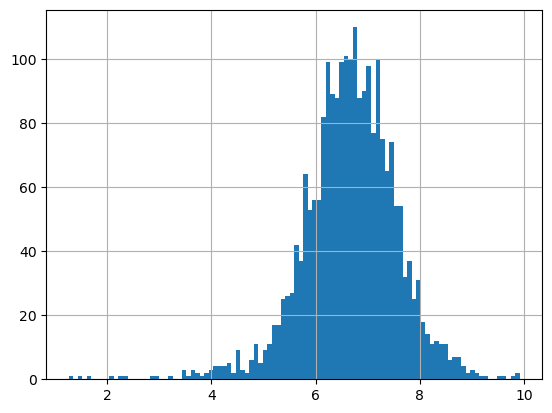

In [14]:
train_adj['sleep_hours'].hist(bins=100)

In [15]:
train_adj = train_adj[train_adj['sleep_hours']> 4]

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. Time Series Forecasting </b></div>

<a id="2.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.1 Facebook Prophet</b></div>

<p style="font-family: consolas; font-size: 16px;">We need to reformat the dataframe column names for Facebook Prophet </p>


In [16]:
pro_train = train_adj.copy()
pro_train = pro_train.rename(columns={'date': 'ds', 'sleep_hours': 'y'})
pro_test = test.copy()
pro_test = pro_test.rename(columns={'date': 'ds', 'sleep_hours': 'y'})

In [17]:
m = Prophet()
m.fit(pro_train)

10:37:02 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = pd.concat([pro_train,pro_test])

In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2692,2023-03-12,7.479306,6.482922,8.514842
2693,2023-03-13,7.164714,6.153002,8.223998
2694,2023-03-14,7.211599,6.244736,8.277647
2695,2023-03-15,7.224434,6.191536,8.317980
2696,2023-03-16,7.431755,6.460361,8.419298


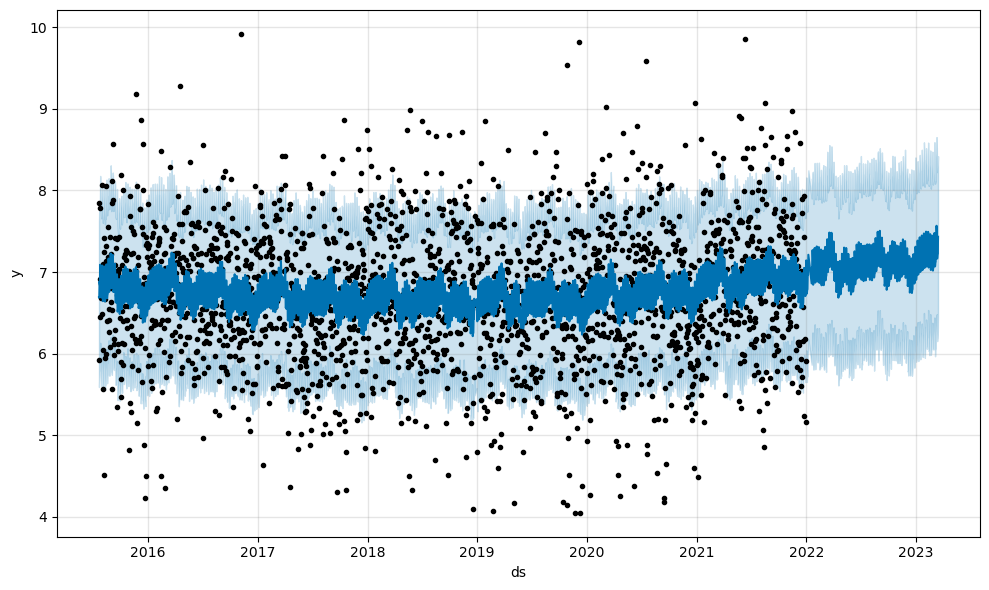

In [20]:
fig1 = m.plot(forecast)


In [21]:
predictions = forecast[(forecast['ds'] >= "2022-01-01") & (forecast['ds'] <= "2023-03-16")]

<a id="2.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.2 ARIMA </b></div>

In [22]:
df = pd.concat([train_adj,test])

train_data = df[:len(df)-419]
test_data = df[len(df)-419:]

In [23]:
auto_arima(train_data['sleep_hours'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [24]:
arima_model = SARIMAX(train_data['sleep_hours'], order = (0, 1, 1),seasonal_order = (0,0,0,12))
arima_result = arima_model.fit()
arima_result.summary()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27935D+00    |proj g|=  1.00251D-01

At iterate    5    f=  1.22782D+00    |proj g|=  1.06537D-02

At iterate   10    f=  1.22350D+00    |proj g|=  8.48940D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     16      1     0     0   4.994D-06   1.223D+00
  F =   1.2234999795750057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            sleep_hours   No. Observations:                 2278
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2787.133
Date:                Wed, 05 Apr 2023   AIC                           5578.266
Time:                        10:37:40   BIC                           5589.727
Sample:                             0   HQIC                          5582.447
                               - 2278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9746      0.005   -206.093      0.000      -0.984      -0.965
sigma2         0.6763      0.018     38.479      0.000       0.642       0.711
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                36.15
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
#Prediction
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")

test_data['sleep_hours'] = arima_pred.values

In [26]:
arima_preds = test_data[['date','sleep_hours']]
arima_preds

,date,sleep_hours
0,2022-01-01,6.768553
1,2022-01-02,6.768553
2,2022-01-03,6.768553
3,2022-01-04,6.768553
4,2022-01-05,6.768553
...,...,...
414,2023-03-12,6.768553
415,2023-03-13,6.768553
416,2023-03-14,6.768553
417,2023-03-15,6.768553


<a id="2.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.2 XGBoost </b></div>

In [27]:
train_xgb = train_adj.copy()
train_xgb['date'] = pd.to_datetime(train_xgb['date'])
train_xgb['day'] = train_xgb['date'].dt.day
train_xgb['dayofweek'] = train_xgb['date'].dt.dayofweek
train_xgb['month'] = train_xgb['date'].dt.month
train_xgb['dayofyear'] = train_xgb['date'].dt.dayofyear
train_xgb['quarter'] = train_xgb['date'].dt.quarter
train_xgb['weekofyear'] = train_xgb['date'].dt.weekofyear

train_xgb

,date,sleep_hours,day_of_week,day,dayofweek,month,dayofyear,quarter,weekofyear
52,2015-07-21,7.850000,Tuesday,21,1,7,202,3,30
53,2015-07-22,5.916667,Wednesday,22,2,7,203,3,30
54,2015-07-23,6.916667,Thursday,23,3,7,204,3,30
55,2015-07-24,6.450000,Friday,24,4,7,205,3,30
56,2015-07-25,7.783333,Saturday,25,5,7,206,3,30
...,...,...,...,...,...,...,...,...,...
2348,2021-12-24,5.233333,Friday,24,4,12,358,4,51
2349,2021-12-25,7.933333,Saturday,25,5,12,359,4,51
2351,2021-12-29,6.175000,Wednesday,29,2,12,363,4,52
2352,2021-12-30,5.158333,Thursday,30,3,12,364,4,52


In [28]:
FEATURES = ['day','dayofweek','month','dayofyear','quarter','weekofyear']
TARGET = 'sleep_hours'

In [29]:
round(len(train_xgb)*0.8)

1822

In [30]:
from sklearn.model_selection import train_test_split

train_xg = train_xgb[:round(len(train_xgb)*0.8)]
test_xg = train_xgb[round(len(train_xgb)*0.8):]

In [31]:
X_train = train_xg[FEATURES]
y_train = train_xg[TARGET]

X_test = test_xg[FEATURES]
y_test = test_xg[TARGET]

In [32]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py

# Creating trace1
trace1 = go.Scatter(
                    x = test_xg.date,
                    y = test_xg.sleep_hours,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'))

data = [trace1]
layout = dict(title = 'Rob Mulla Sleeping Hours',
              xaxis= dict(title= 'Date',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

<a id="2.3.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:18px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.3.1 XGBoost Hyperparameter Tuning with Hyperopt</b></div>

In [33]:
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

#Define the space over which hyperopt will search for optimal hyperparameters.
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
        'gamma': hp.uniform ('gamma', 0,1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,50),
        'reg_lambda' : hp.uniform('reg_lambda', 10,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
        'n_estimators': 10000,
        'learning_rate': hp.uniform('learning_rate', 0, .15),
        'tree_method':'gpu_hist', 
        'gpu_id': 0,
        'random_state': 5,
        'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [34]:
#Define the hyperopt objective.
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)
    
    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

    #Obtain prediction and rmse score.
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print ("SCORE:", rmse)
    
    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

In [35]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:
0.8387147823696907
SCORE:
0.8337889036839676
SCORE:
0.8347701628392422
SCORE:
0.8380208761720854
SCORE:
0.8378605985773317
SCORE:
0.8380971977616113
SCORE:
0.8368692015524489
SCORE:
0.8351369497809025
SCORE:
0.8341589344320106
SCORE:
0.834334806803525
SCORE:
0.840255164772903
SCORE:
0.8342583388028529
SCORE:
0.8349099577700074
SCORE:
0.8369519594709101
SCORE:
0.8364573520011828
SCORE:
0.8350736161140379
SCORE:
0.8375002044301686
SCORE:
0.8353829092804756
SCORE:
0.8341998350279811
SCORE:
0.8369323371415084
SCORE:
0.8336978966912637
SCORE:
0.833556347695035
SCORE:
0.8330181914372693
SCORE:
0.8325413076413584
SCORE:
0.8360791396096319
SCORE:
0.8310814448257973
SCORE:
0.8348337224761233
SCORE:
0.8364019982307969
SCORE:
0.8325934687620201
SCORE:
0.8326104019710948
100%|██████████| 30/30 [00:13<00:00,  2.20trial/s, best loss: 0.8310814448257973]
{'colsample_bytree': 0.5431788638257252, 'gamma': 0.008550265506953002, 'learning_rate': 0.1360848431400414, 'max_bin': 290.0, 'max_depth': 1

In [36]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.5431788638257252, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.008550265506953002, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1360848431400414, max_bin=290, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=1, max_leaves=0,
             min_child_weight=2.9713119931370926, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=5,
             reg_alpha=26.65818528254922, reg_lambda=44.87373693758134, ...)


In [37]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

xgb_standard = xgb.XGBRegressor().fit(X_train, y_train)
standard_score = mean_squared_error(y_test, xgb_standard.predict(X_test), squared=False)
print('RMSE_Standard_Model:', standard_score)

RMSE_Best_Model: 0.8310814448257973
RMSE_Standard_Model: 0.9475154356876873


In [38]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])

<AxesSubplot:title={'center':'feature importance'}>

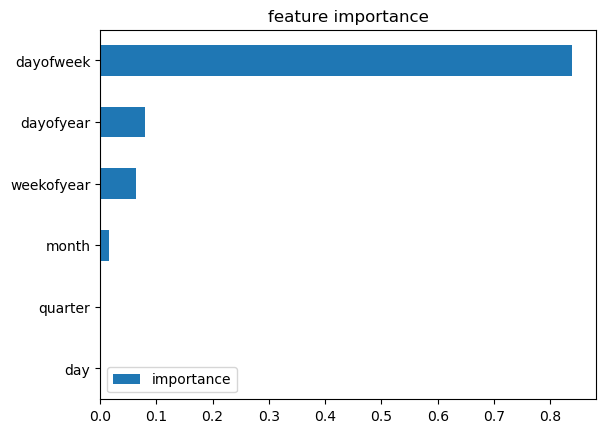

In [39]:
fi.sort_values('importance').plot(kind='barh',title='feature importance')

In [40]:
test_xg['prediction'] = best_model.predict(X_test)
df = train_xgb.copy()
df = df.merge(test_xg[['prediction']], how='left',left_index=True, right_index=True)
df

,date,sleep_hours,day_of_week,day,dayofweek,month,dayofyear,quarter,weekofyear,prediction
52,2015-07-21,7.850000,Tuesday,21,1,7,202,3,30,NaN
53,2015-07-22,5.916667,Wednesday,22,2,7,203,3,30,NaN
54,2015-07-23,6.916667,Thursday,23,3,7,204,3,30,NaN
55,2015-07-24,6.450000,Friday,24,4,7,205,3,30,NaN
56,2015-07-25,7.783333,Saturday,25,5,7,206,3,30,NaN
...,...,...,...,...,...,...,...,...,...,...
2348,2021-12-24,5.233333,Friday,24,4,12,358,4,51,6.638997
2349,2021-12-25,7.933333,Saturday,25,5,12,359,4,51,6.767250
2351,2021-12-29,6.175000,Wednesday,29,2,12,363,4,52,6.479952
2352,2021-12-30,5.158333,Thursday,30,3,12,364,4,52,6.638997


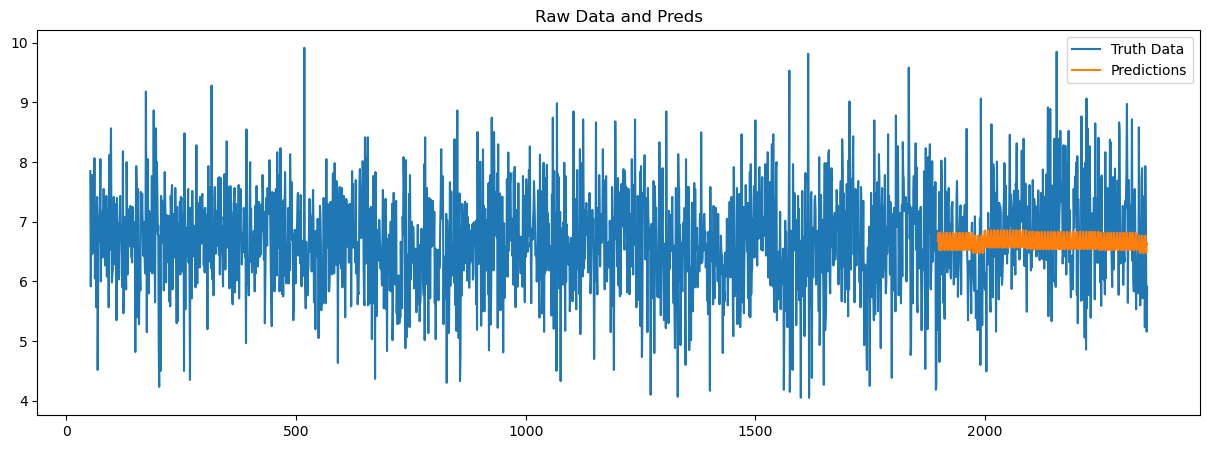

In [41]:
ax = df[['sleep_hours']].plot(figsize=(15,5))
df[['prediction']].plot(ax=ax)
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Preds')
plt.show()

In [42]:
def format_df(df):
    df_x = df.copy()
    df_x['date'] = pd.to_datetime(df_x['date'])
    df_x['day'] = df_x['date'].dt.day
    df_x['dayofweek'] = df_x['date'].dt.dayofweek
    df_x['month'] = df_x['date'].dt.month
    df_x['dayofyear'] = df_x['date'].dt.dayofyear
    df_x['quarter'] = df_x['date'].dt.quarter
    df_x['weekofyear'] = df_x['date'].dt.weekofyear
    return df_x

In [43]:
xgb_test = format_df(test)
xgb_test = xgb_test[FEATURES]
xgb_test['predictions'] = best_model.predict(xgb_test)
xgb_test['date'] = test['date']
xgb_test

,day,dayofweek,month,dayofyear,quarter,weekofyear,predictions,date
0,1,5,1,1,1,52,6.852791,2022-01-01
1,2,6,1,2,1,52,6.852791,2022-01-02
2,3,0,1,3,1,1,6.569053,2022-01-03
3,4,1,1,4,1,1,6.569053,2022-01-04
4,5,2,1,5,1,1,6.569053,2022-01-05
...,...,...,...,...,...,...,...,...
414,12,6,3,71,1,10,6.856351,2023-03-12
415,13,0,3,72,1,11,6.569053,2023-03-13
416,14,1,3,73,1,11,6.569053,2023-03-14
417,15,2,3,74,1,11,6.569053,2023-03-15


In [44]:
xgb_preds = xgb_test[['date','predictions']]
xgb_preds


,date,predictions
0,2022-01-01,6.852791
1,2022-01-02,6.852791
2,2022-01-03,6.569053
3,2022-01-04,6.569053
4,2022-01-05,6.569053
...,...,...
414,2023-03-12,6.856351
415,2023-03-13,6.569053
416,2023-03-14,6.569053
417,2023-03-15,6.569053


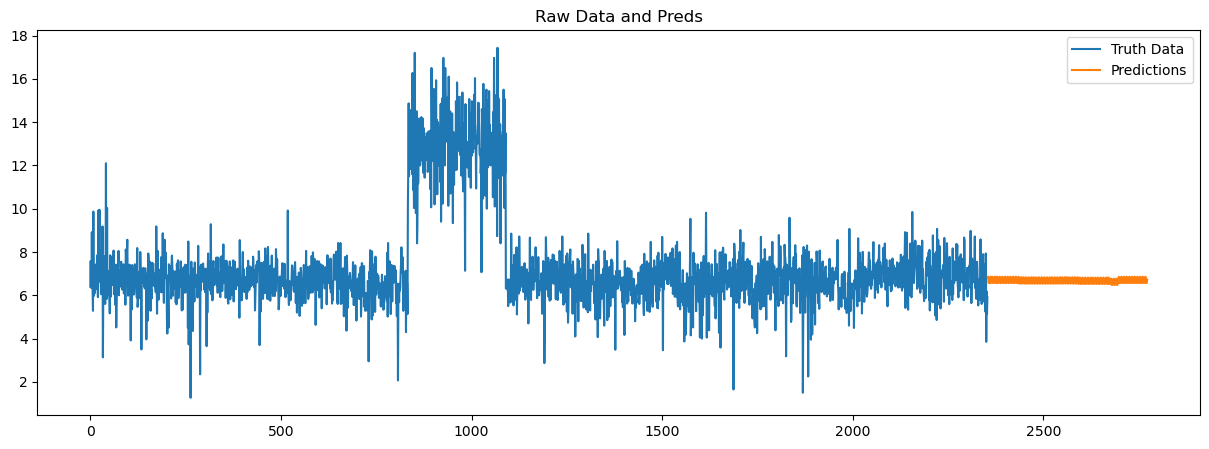

In [45]:
df1 = pd.concat([train,xgb_preds])
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.reset_index()
df1
ax = df1['sleep_hours'].plot(figsize=(15,5))
df1['predictions'].plot(ax=ax)
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Preds')
plt.show()

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3 Submission </b></div>

<a id="3.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:18px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 3.1 Prophet Submission</b></div>

In [46]:
submission = predictions[['ds','yhat']].copy()
submission = submission.rename(columns={'ds': 'date', 'yhat': 'sleep_hours'})
# submission.to_csv('submission.csv',index=False)



<a id="3.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:18px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 3.2 ARIMA Submission</b></div>

In [47]:
arima_adj = arima_preds.copy()
# arima_adj.to_csv('submission.csv',index=False)

<a id="3.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:18px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 3.3 XGBoost Submission</b></div>

In [48]:
xgb_preds = xgb_preds.rename(columns={'predictions':'sleep_hours'})

# xgb_preds.to_csv('submission.csv',index=False)

In [49]:
submission['arima_pred'] = arima_preds['sleep_hours'].values
submission['xgb_pred'] = xgb_preds['sleep_hours'].values

submission = submission.rename(columns={'sleep_hours':'prophet','arima_pred':'arima','xgb_pred':'xgb'})

In [50]:
submission['sleep_hours'] = submission[['prophet', 'arima','xgb']].mean(axis=1)

In [51]:
sub = submission[['date','sleep_hours']]
sub.to_csv('submission.csv',index=False)


In [52]:
pd.read_csv('/kaggle/working/submission.csv')

,date,sleep_hours
0,2022-01-01,6.921211
1,2022-01-02,6.891402
2,2022-01-03,6.690961
3,2022-01-04,6.705487
4,2022-01-05,6.708624
...,...,...
414,2023-03-12,7.034737
415,2023-03-13,6.834107
416,2023-03-14,6.849735
417,2023-03-15,6.854014
